In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tensorflow import keras
from tensorflow.keras import layers

2024-11-13 16:03:06.428400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 16:03:07.171221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### __1. Import and data pre-processing:__

In [2]:
# import counts dataframe:

df_counts = pd.read_csv("../dataset/mdd_counts.csv") 
df_counts = df_counts.set_index("Unnamed: 0")

print(df_counts.shape)
df_counts.head()

(281, 1052)


,ENSG00000004059,ENSG00000004776,ENSG00000006015,ENSG00000006283,ENSG00000007062,ENSG00000008300,ENSG00000008323,ENSG00000008382,ENSG00000011566,ENSG00000013725,...,ENSG00000263142,ENSG00000268500,ENSG00000268598,ENSG00000269343,ENSG00000269858,ENSG00000269955,ENSG00000270326,ENSG00000270585,ENSG00000271207,ENSG00000272636
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
14.aINS,8.996242,0.103986,2.621305,1.610692,1.495194,2.045752,0.00000,2.184767,21.565145,0.049781,...,0.611700,0.0,0.529774,2.442070,0.862148,0.0,1.855580,0.000000,0.000000,5.121861
17.aINS,8.903824,0.436902,2.950058,3.044226,0.986233,2.577052,0.00000,2.858730,18.016300,0.053784,...,1.027330,0.0,0.635963,2.128504,1.152073,0.0,2.227519,0.242431,0.039514,5.773299
20.aINS,11.186563,0.365299,3.003535,2.308878,1.807888,2.433533,0.00000,2.651374,20.614090,0.095389,...,0.552249,0.0,0.676757,2.912190,1.356395,0.0,1.185201,0.085994,0.042048,4.829895
23.aINS,10.507356,0.144972,2.333444,2.918354,1.254059,2.282867,0.01465,2.406256,19.575888,0.093694,...,0.787202,0.0,0.369292,2.499131,1.252572,0.0,1.293479,0.187700,0.000000,4.259085
28.aINS,11.416718,0.305866,2.083884,1.916791,1.371925,2.001595,0.00000,1.999301,20.719654,0.087857,...,0.945770,0.0,0.173143,2.483541,1.112255,0.0,1.212900,0.176007,0.000000,6.010410


In [3]:
# import metadata:

df_meta = pd.read_csv("../dataset/mdd_meta.csv")
df_meta = df_meta.set_index("!Sample_title")
df_meta.head()

,14,17,20,23,28,32,40,43,45,51,...,205,212,222,235,236,238,242,246,247,249
!Sample_title,,,,,,,,,,,,,,,,,,,,,
gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Female,Female,Female,Female,Female,Female,Female,Female,Male,Female
cause of death,Natural,Natural,Accident,Suicide,Natural,Suicide,Suicide,Suicide,Suicide,Suicide,...,Suicide,Natural,Suicide,Suicide,Suicide,Suicide,Natural,Suicide,Accident,Suicide
age,47,41,31,19,46,40,49,33,38,53,...,48,82,36,52,60,22,68,59,59,51
phenotype,CTRL,CTRL,CTRL,CTRL,CTRL,CTRL,MDD,CTRL,CTRL,MDD,...,MDD,CTRL,MDD,MDD,CTRL,CTRL,CTRL,MDD,CTRL,CTRL


0.0 11.84080508726906 8427.35517600903


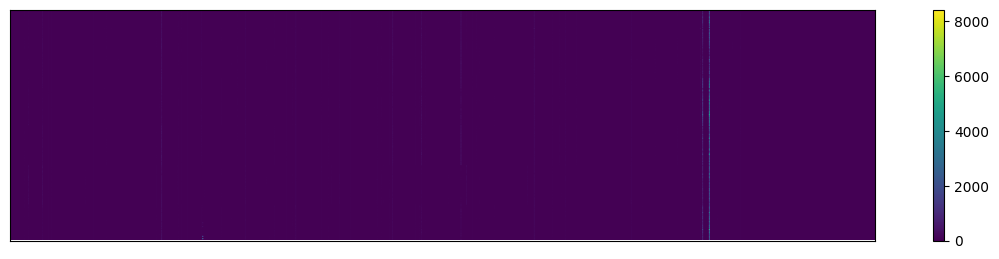

In [4]:
# select (x, y) data:
# x -> counts table
# y -> (sample, phenotype, denger)

counts = df_counts.to_numpy()
print(counts.min(), counts.mean(), counts.max())

plt.figure(figsize=(15,3))
plt.imshow(counts)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

0.0 0.1568379641609071 1.0


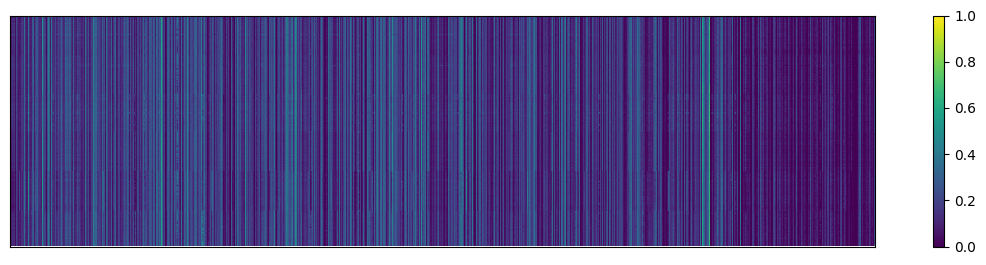

In [5]:
# normalization:
x = np.log(counts+1)
x_max = x.max()
x /= x_max

print(x.min(), x.mean(), x.max())

plt.figure(figsize=(15,3))
plt.imshow(x)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# meta -> (subject_id, sample, phenotype, gender)

meta = [x.split(".") for x in df_counts.index]

N = len(meta)

for i in range(N):
    n = meta[i][0]
    
    meta[i] += df_meta.loc[['phenotype', 'gender'], n].tolist()

meta = np.array(meta)
print(meta.shape)
meta

(281, 4)


array([['14', 'aINS', 'CTRL', 'Male'],
       ['17', 'aINS', 'CTRL', 'Male'],
       ['20', 'aINS', 'CTRL', 'Male'],
       ...,
       ['246', 'Sub', 'MDD', 'Female'],
       ['247', 'Sub', 'CTRL', 'Male'],
       ['249', 'Sub', 'CTRL', 'Female']], dtype='<U6')

In [7]:
# one-hot encoding:

def one_hot(meta):

    labels = np.array(list(set(meta)))
    hot = np.zeros((len(meta), len(labels)))

    for i, x in enumerate(meta):
        j = np.where(x == labels)[0]
        hot[i][j] = 1.0

    return hot

y1 = one_hot(meta.T[1])
y2 = one_hot(meta.T[2])
y3 = one_hot(meta.T[3])

print(f"y1:{y1.shape}, y2:{y2.shape}, y3:{y3.shape}")

y1[:2], y2[:2], y3[:2]

y1:(281, 6), y2:(281, 2), y3:(281, 2)


(array([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]]),
 array([[0., 1.],
        [0., 1.]]),
 array([[1., 0.],
        [1., 0.]]))

In [8]:
# shuffling:
N_samples = x.shape[0]
i = np.random.permutation(N_samples)

x, y1, y2, y3 = x[i], y1[i], y2[i], y3[i]
meta = meta[i]

x.shape, y1.shape, y2.shape, y3.shape

((281, 1052), (281, 6), (281, 2), (281, 2))

In [9]:
# add channel for convnet:
x = np.expand_dims(x, axis=-1)
x.shape

(281, 1052, 1)

In [10]:
# splitting (x, y) into (x, x-test):
N_test = int(0.10*N_samples)

x_test = x[:N_test]
x = x[N_test:]

print(f"x:{x.shape}, x-test:{x_test.shape}")

y1_test = y1[:N_test]
y1 = y1[N_test:]

print(f"y1:{y1.shape}, y1-test:{y1_test.shape}")

y2_test = y2[:N_test]
y2 = y2[N_test:]

print(f"y2:{y2.shape}, y2-test:{y2_test.shape}")

y3_test = y3[:N_test]
y3 = y3[N_test:]

print(f"y3:{y3.shape}, y3-test:{y3_test.shape}")


x:(253, 1052, 1), x-test:(28, 1052, 1)
y1:(253, 6), y1-test:(28, 6)
y2:(253, 2), y2-test:(28, 2)
y3:(253, 2), y3-test:(28, 2)


In [11]:
# deleting unnecessary arrays:
del df_counts, df_meta, counts

### __2. Neural network modeling:__

In [12]:
def Encoder(params_dim=[1, 1, 1], act="relu", kernel_size=5):
    
    input_size = 1052
    
    In = keras.Input((input_size, 1))
    
    x = layers.Conv1D(32, kernel_size, activation=act, padding="same")(In)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(64, kernel_size, activation=act, padding="same")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    
    Out = []
    for n, dim in enumerate(params_dim):
        Out.append(layers.Dense(dim, activation="softmax", name=f"ls{n+1}")(x))
    
    return keras.Model(inputs=In, outputs=Out, name='encoder')

params_dim = [y1.shape[1], y2.shape[1], y3.shape[1]]
encoder = Encoder(params_dim=params_dim, act="elu", kernel_size=5)

encoder.summary()

2024-11-13 16:03:09.097412: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1052, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1052, 32)  │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 526, 32)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 526, 64)   │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 263, 64)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 263)       │          0 │ max_pooling1d_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls1 (Dense)         │ (None, 6)         │      1,584 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls2 (Dense)         │ (None, 2)         │        528 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls3 (Dense)         │ (None, 2)         │        528 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,136 (51.31 KB)

 Trainable params: 13,136 (51.31 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def Decoder(params_dim=[1, 1, 1], act="relu", kernel_size=5):

    In = []
    for dim in params_dim:
        In.append(layers.Input((dim, )))

    x = layers.Concatenate()(In)
    
    x = layers.Dense(263, activation=act)(x)

    x = layers.Dense(263*64, activation=act)(x)
    x = layers.Reshape((263, 64))(x)
    
    x = layers.Conv1DTranspose(64, kernel_size, activation=act, strides=2, padding="same")(x)
    x = layers.Conv1DTranspose(32, kernel_size, activation=act, strides=2, padding="same")(x)

    Out = layers.Conv1D(1, kernel_size, activation="sigmoid", padding="same", name="x_hat")(x)
    
    return keras.Model(inputs=In, outputs=Out, name='decoder')

params_dim = params_dim
decoder = Decoder(params_dim=params_dim, act="elu", kernel_size=5)

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 263)       │      2,893 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16832)     │  4,443,648 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 263, 64)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 526, 64)   │     20,544 │ reshape[0][0]     │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_1  │ (None, 1052, 32)  │     10,272 │ conv1d_transpose… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_hat (Conv1D)      │ (None, 1052, 1)   │        161 │ conv1d_transpose… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,477,518 (17.08 MB)

 Trainable params: 4,477,518 (17.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def MyModel(params_dim=[1, 1, 1], act="relu", kernel_size=5):

    encoder = Encoder(params_dim, act, kernel_size)
    decoder = Decoder(params_dim, act, kernel_size)

    return keras.Model(inputs=[encoder.input, decoder.input], 
                       outputs=[encoder.output, decoder.output], 
                       name='autoencoder'), encoder, decoder

model, encoder, decoder = MyModel(params_dim=params_dim, act="elu", kernel_size=5)
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1052, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10)        │          0 │ input_layer_5[0]… │
│ (Concatenate)       │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1052, 32)  │        192 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 263)       │      2,893 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 526, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16832)     │  4,443,648 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 526, 64)   │     10,304 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 263, 64)   │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 263, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_2  │ (None, 526, 64)   │     20,544 │ reshape_1[0][0]   │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 263)       │          0 │ max_pooling1d_3[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose_3  │ (None, 1052, 32)  │     10,272 │ conv1d_transpose… │
│ (Conv1DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls1 (Dense)         │ (None, 6)         │      1,584 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls2 (Dense)         │ (None, 2)         │        528 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ls3 (Dense)         │ (None, 2)         │        528 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_hat (Conv1D)      │ (None, 1052, 1)   │        161 │ conv1d_transpose… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 4,490,654 (17.13 MB)

 Trainable params: 4,490,654 (17.13 MB)

 Non-trainable params: 0 (0.00 B)

### __3. Model compilation:__

In [15]:
model.compile(optimizer="Adam", loss=3*["categorical_crossentropy"]+["mse"], metrics=3*["acc"]+["mae"])

### __4. K-fold cross-validation:__   

### __5. Final training__    

In [ ]:
report = model.fit(x=[x, [y1, y2, y3]], y=[[y1, y2, y3], x], epochs=20, batch_size=1)

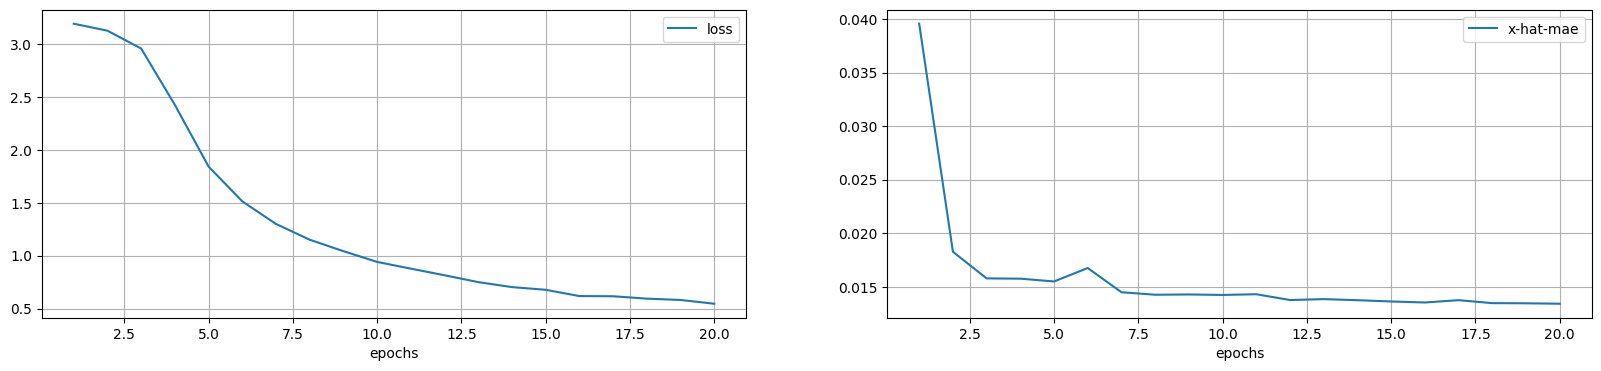

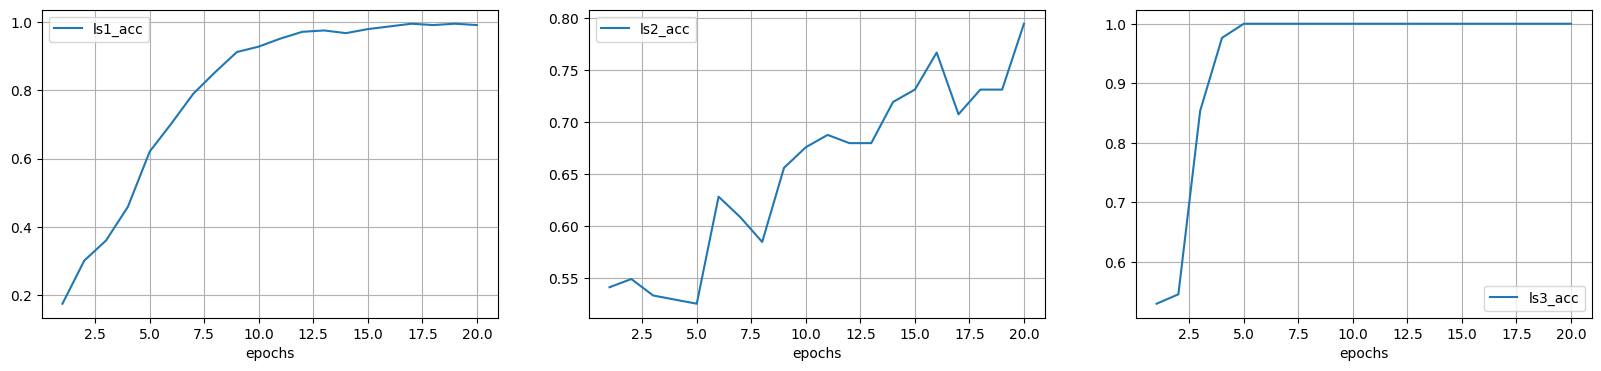

In [17]:
loss = report.history['loss']
ls1_acc = report.history['ls1_acc']
ls2_acc = report.history['ls2_acc']
ls3_acc = report.history['ls3_acc']
x_hat_mae = report.history['x_hat_mae']

epochs = np.linspace(1, len(loss), len(loss))

fig, ax = plt.subplots(1, 2, figsize=(20,4))

ax[0].plot(epochs, loss, label="loss")
ax[1].plot(epochs, x_hat_mae, label="x-hat-mae")

for i in range(2):
    ax[i].set_xlabel("epochs")
    ax[i].legend()
    ax[i].grid()

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20,4))

ax[0].plot(epochs, ls1_acc, label="ls1_acc")
ax[1].plot(epochs, ls2_acc, label="ls2_acc")
ax[2].plot(epochs, ls3_acc, label="ls3_acc")

for i in range(3):
    ax[i].set_xlabel("epochs")
    ax[i].legend()
    ax[i].grid()

plt.show()

### __6. Test evaluation__:

In [18]:
model.evaluate(x=[x_test, [y1_test, y2_test, y3_test]], 
               y=[[y1_test, y2_test, y3_test], x_test], 
               batch_size=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8719 - ls1_acc: 1.0000 - ls1_loss: 0.0820 - ls2_acc: 0.5351 - ls2_loss: 0.7629 - ls3_acc: 1.0000 - ls3_loss: 0.0265 - x_hat_loss: 4.5784e-04 - x_hat_mae: 0.0140  


[0.8267641067504883,
 0.07071461528539658,
 0.7313991189002991,
 0.024238111451268196,
 0.00041236853576265275,
 1.0,
 0.6071428656578064,
 1.0,
 0.013475092127919197]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


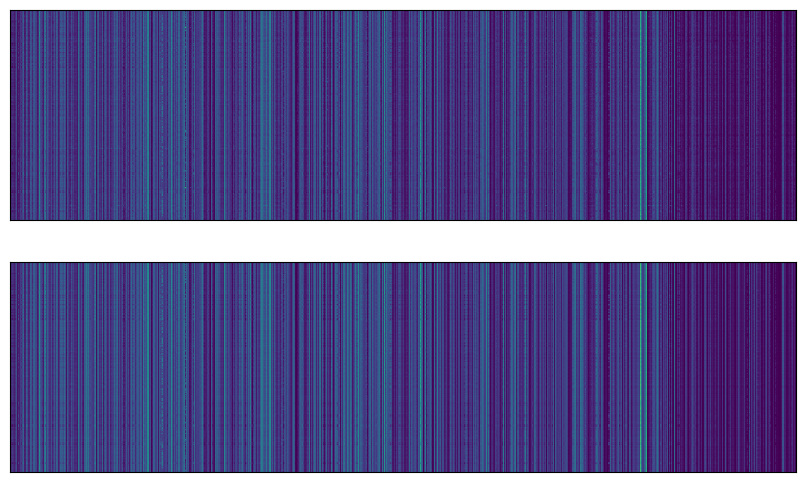

In [19]:
x = np.concatenate([x_test, x])

y1 = np.concatenate([y1_test, y1])
y2 = np.concatenate([y2_test, y2])
y3 = np.concatenate([y3_test, y3])

y_pred, x_pred = model.predict([x, [y1, y2, y3]])

fig, ax = plt.subplots(2, 1, figsize=(15, 6))

ax[0].imshow(x)
ax[1].imshow(x_pred)

for i in range(2):        
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

#### __6.1 Anomaly detection:__

In [20]:
mse = np.mean(pow(x-x_pred, 2), axis=1)

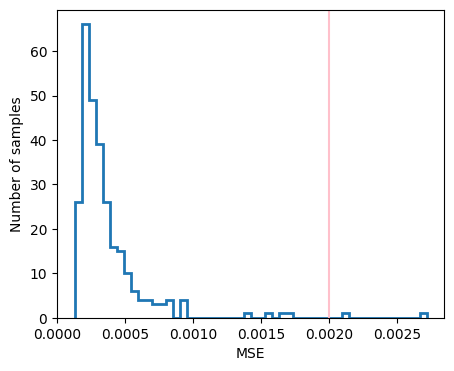

Outliers:
 [['113' 'aINS' 'MDD' 'Male']
 ['113' 'Cg25' 'MDD' 'Male']]


In [21]:
threshold = 0.002

plt.figure(figsize=(5,4))
plt.hist(mse, bins=50, histtype="step", lw=2)
plt.axvline(x=threshold, color='pink')
plt.xlabel("MSE")
plt.ylabel("Number of samples")
plt.show()

j = np.where(mse >= threshold)[0]

print("Outliers:\n", meta[j])

#### __6.2 Classification:__

In [22]:
def classifier(x):

    l1 = list(set(meta.T[1]))
    l2 = list(set(meta.T[2]))
    l3 = list(set(meta.T[3]))
    
    y_hat = encoder(x)

    meta_hat = []    
    for y1_hat, y2_hat, y3_hat in zip(*y_hat):

        j1 = np.argmax(y1_hat)
        j2 = np.argmax(y2_hat)
        j3 = np.argmax(y3_hat)
        
        meta_hat.append([l1[j1], l2[j2], l3[j3]])

    return np.array(meta_hat)
        
meta_hat = classifier(x)

In [23]:
n = np.random.randint(low=0, high=len(meta), size=5)

for m1, m2 in zip(meta.T[1:].T[n], meta_hat[n]):
    print("m1", m1)
    print("m2", m2)
    print("  ", m1 == m2, "\n")
    

m1 ['Nac' 'MDD' 'Female']
m2 ['Nac' 'MDD' 'Female']
   [ True  True  True] 

m1 ['Sub' 'CTRL' 'Male']
m2 ['Sub' 'CTRL' 'Male']
   [ True  True  True] 

m1 ['OFC' 'MDD' 'Male']
m2 ['OFC' 'CTRL' 'Male']
   [ True False  True] 

m1 ['Cg25' 'CTRL' 'Female']
m2 ['Cg25' 'CTRL' 'Female']
   [ True  True  True] 

m1 ['aINS' 'CTRL' 'Male']
m2 ['aINS' 'CTRL' 'Male']
   [ True  True  True] 



#### __6.3 Data generator:__

In [24]:
def generator(y):

    l1 = np.array(list(set(meta.T[1])))
    l2 = np.array(list(set(meta.T[2])))
    l3 = np.array(list(set(meta.T[3])))

    y1 = np.zeros((1, l1.size))
    y2 = np.zeros((1, l2.size))
    y3 = np.zeros((1, l3.size))

    j1 = np.where(y[0] == l1)[0][0]
    j2 = np.where(y[1] == l2)[0][0]
    j3 = np.where(y[2] == l3)[0][0]
    
    y1[0, j1] = 1 
    y2[0, j2] = 1 
    y3[0, j3] = 1 
    
    x_hat = decoder([y1, y2, y3])

    x_hat = x_hat[0].numpy()
    x_hat = np.squeeze(x_hat, axis=-1)
    x_hat *= x_max
    counts_hat = np.exp(x_hat) - 1
    
    return counts_hat

counts_hat = generator(['Cg25', 'MDD', 'Male'])
counts_hat

array([ 8.968207  ,  0.71709883,  5.410056  , ...,  0.07642925,
        0.06193137, 10.886316  ], dtype=float32)

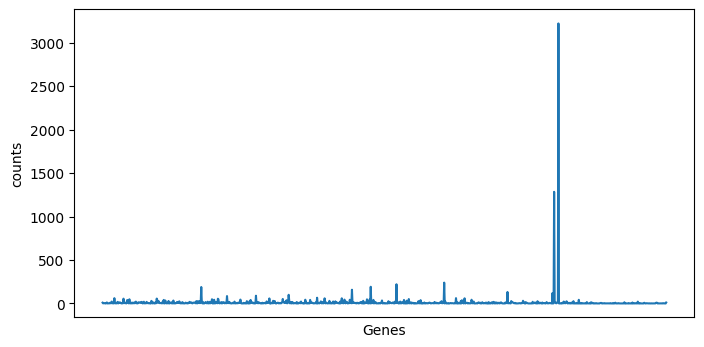

In [25]:
plt.figure(figsize=(8,4))
plt.plot(counts_hat)
plt.xlabel("Genes")
plt.ylabel("counts")
plt.xticks([])
plt.show()

### __7. Saving the model__:
<font size=3>
    
For model __loading__, see [2.3-handson-loading_model](../2-over_vs_underfitting/2.3-handson-loading_model.ipynb).